# Import Libraries

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable

from PIL import Image
import cv2
import albumentations as A

import time
import os
from tqdm.notebook import tqdm

!pip install -q segmentation-models-pytorch
!pip install -q torchsummary

from torchsummary import summary
import segmentation_models_pytorch as smp

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyterlab-git 0.11.0 requires nbdime<2.0.0,>=1.1.0, but you have nbdime 2.1.0 which is incompatible.
bokeh 2.2.3 requires tornado>=5.1, but you have tornado 5.0.2 which is incompatible.
autogluon-core 0.1.0b20210210 requires numpy==1.19, but you have numpy 1.19.5 which is incompatible.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
class CFG:
    current_fold = 5
    n_classes = 13 
    IMAGE_PATH = '/kaggle/input/self-driving-car-semantic-segmentation/CameraRGB/'
    MASK_PATH = '/kaggle/input/self-driving-car-semantic-segmentation/CameraSeg/'
    max_lr = 1e-3
    epoch = 25
    weight_decay = 1e-4



# Preprocessing

In [3]:
def create_df():
    name = []
    for dirname, _, filenames in os.walk(CFG.IMAGE_PATH):
        for filename in filenames:
            name.append(filename.split('.')[0])
    
    return pd.DataFrame({'id': name}, index = np.arange(0, len(name)))

df = create_df()
print('Total Images: ', len(df))

Total Images:  1000


In [4]:
df.head()

,id
0,F69-95
1,F67-59
2,F66-49
3,F69-5
4,F63-6


In [5]:
df[['VideoName', 'FrameNumber']] = df['id'].str.split('-', expand=True)


In [6]:

# Convert 'FrameNumber' to integer type for proper sorting
df['FrameNumber'] = df['FrameNumber'].astype(int)

# Sort the DataFrame first by 'VideoName' and then by 'FrameNumber'
df_sorted = df.sort_values(by=['VideoName', 'FrameNumber'])

# Print the sorted DataFrame
print(df_sorted)

          id VideoName  FrameNumber
881    F61-1       F61            1
876    F61-2       F61            2
381    F61-3       F61            3
893    F61-4       F61            4
314    F61-5       F61            5
..       ...       ...          ...
464   F70-96       F70           96
313   F70-97       F70           97
472   F70-98       F70           98
786   F70-99       F70           99
481  F70-100       F70          100

[1000 rows x 3 columns]


In [7]:
df = df_sorted
df = df.reset_index(drop=True)

In [8]:
unique_video_names = df['VideoName'].unique()

# Define the number of videos per fold
videos_per_fold = 10

# Create a custom cross-validation iterator
class CustomKFold:
    def __init__(self, n_splits, video_names):
        self.n_splits = n_splits
        self.video_names = video_names

    def split(self, X=None, y=None, groups=None):
        indices = list(range(len(self.video_names)))
        for fold in range(self.n_splits):
            test_video = [self.video_names[fold]]
            validation_video = [self.video_names[(fold + 1) % self.n_splits]]
            train_videos = [self.video_names[i] for i in range(len(self.video_names)) if i != fold and i != (fold + 1) % self.n_splits]
            yield train_videos, validation_video, test_video

kf = CustomKFold(n_splits=videos_per_fold, video_names=unique_video_names)

# Get the corresponding train, validation, and test video names
for fold, (train_video_names, val_video_names, test_video_names) in enumerate(kf.split(), start=1):
    if fold == CFG.current_fold:
        break

# Create train, validation, and test DataFrames based on the selected video names
train_df = df[df['VideoName'].isin(train_video_names)].reset_index(drop=True)
val_df = df[df['VideoName'].isin(val_video_names)].reset_index(drop=True)
test_df = df[df['VideoName'].isin(test_video_names)].reset_index(drop=True)

print(f"Fold {CFG.current_fold}:")
print("Train set size:", len(train_df))
print("Validation set size:", len(val_df))
print("Test set size:", len(test_df))

Fold 5:
Train set size: 800
Validation set size: 100
Test set size: 100


In [9]:
X_train, X_val, X_test = train_df.id.values, val_df.id.values , test_df.id.values

In [10]:
color_map = {
    0: [128, 64, 128],     # Background (Purple)
    1: [220, 20, 60],    # Building (Red)
    2: [244, 35, 232],    # Sidewalk (Pink)
    3: [70, 130, 180],      # Traffic Sign (Blue)
    4: [102, 102, 156],   # Wall (Light Gray)
    5: [190, 153, 153],   # Fence (Light Gray)
    6: [153, 153, 153],   # Pole (Gray)
    7: [250, 170, 30],    # Road (Orange)
    8: [220, 220, 0],     # Traffic Light (Yellow)
    9: [107, 142, 35],    # Vegetation (Green)
    10: [152, 251, 152],  # Terrain (Light Green)
    11: [70, 70, 70],   # Sky (Dark Gray)
    12: [0, 0, 0],    # Person/Cyclist (Black)
}

Image Size (600, 800, 3)
Mask Size (600, 800, 3)
12 0


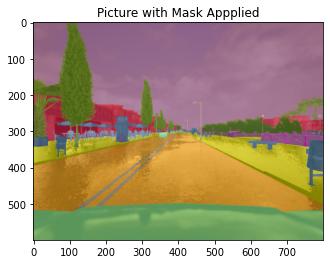

Image Size (600, 800, 3)
Mask Size (600, 800, 3)
12 0


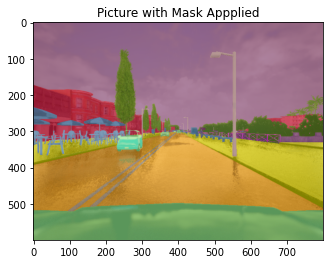

Image Size (600, 800, 3)
Mask Size (600, 800, 3)
12 0


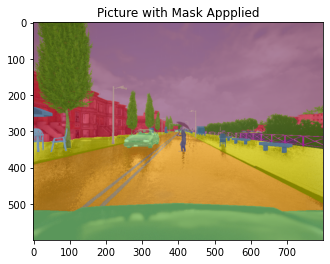

Image Size (600, 800, 3)
Mask Size (600, 800, 3)
12 0


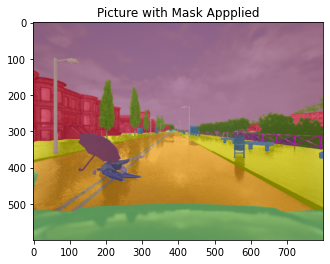

Image Size (600, 800, 3)
Mask Size (600, 800, 3)
12 0


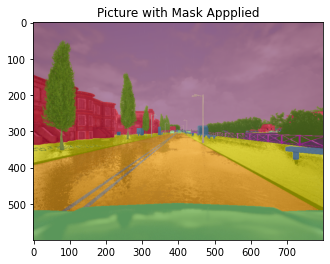

In [11]:
for i in range(0,len(test_df), 20):
    img = Image.open(CFG.IMAGE_PATH + test_df['id'][i] + '.png')
    mask = Image.open(CFG.MASK_PATH + test_df['id'][i] + '.png')
    print('Image Size', np.asarray(img).shape)
    print('Mask Size', np.asarray(mask).shape)
    print(np.asarray(mask).max(), np.asarray(mask).min())
    # Convert the mask to a numpy array
    mask_array = np.array(mask)

    # Create an empty canvas for color visualization
    colored_mask = np.zeros((mask_array.shape[0], mask_array.shape[1], 3), dtype=np.uint8)

    # Iterate over each pixel in the mask
    for row in range(mask_array.shape[0]):
        for col in range(mask_array.shape[1]):
            class_id = mask_array[row, col][0]
            colored_mask[row, col] = color_map[class_id]

    plt.imshow(img)
    plt.imshow(colored_mask, alpha=0.6)
    plt.title('Picture with Mask Appplied')
    plt.show()

# Create Video from images

In [12]:
def create_video(images, masks, output = '/kaggle/working/output_video.mp4'):
    # Define the frame width, height, and frames per second
    print(np.asarray(images[0]).shape)
    frame_width, frame_height = np.asarray(images[0]).shape[1], np.asarray(images[0]).shape[0]
    fps = 10
    
    # Define the codec and create a VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter(output, fourcc, fps, (frame_width, frame_height))
    
    for i in range(10):
        img = np.asarray(images[i])
        mask_array = np.array(masks[i])
        
        colored_mask = np.zeros((mask_array.shape[0], mask_array.shape[1], 3), dtype=np.uint8)
        
        for row in range(mask_array.shape[0]):
            for col in range(mask_array.shape[1]):
                class_id = mask_array[row, col][0]
                colored_mask[row, col] = color_map[class_id]
        
        # Overlay the colored mask on the image
        img_with_mask = cv2.addWeighted(img, 1, colored_mask, 0.6, 0)
        
        # Write the frame to the video
        out.write(img_with_mask)
    
    # Release the VideoWriter
    out.release()


In [13]:

def create_all_videos(images, masks, output_prefix = f'output_video_{CFG.current_fold}'):
    # Define the frame width, height, and frames per second
    frame_width, frame_height = np.asarray(images[0]).shape[1], np.asarray(images[0]).shape[0]
    fps = 9
    
    # Define the codec and create VideoWriter objects for each video
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    
    original_video_out = cv2.VideoWriter(f"{output_prefix}_original.mp4", fourcc, fps, (frame_width, frame_height))
    mask_video_out = cv2.VideoWriter(f"{output_prefix}_mask.mp4", fourcc, fps, (frame_width, frame_height))
    combined_video_out = cv2.VideoWriter(f"{output_prefix}_combined.mp4", fourcc, fps, (frame_width, frame_height))
    
    for i in range(len(images)):
        img = np.asarray(images[i])
        mask_array = np.array(masks[i])
        
        colored_mask = np.zeros((mask_array.shape[0], mask_array.shape[1], 3), dtype=np.uint8)
        
        for row in range(mask_array.shape[0]):
            for col in range(mask_array.shape[1]):
                class_id = mask_array[row, col][0]
                colored_mask[row, col] = color_map[class_id]
        
        # Overlay the colored mask on the image
        img_with_mask = cv2.addWeighted(img, 1, colored_mask, 0.6, 0)
        
        # Write frames to the videos
        original_video_out.write(img)
        mask_video_out.write(colored_mask)
        combined_video_out.write(img_with_mask)
    
    # Release the VideoWriter objects
    original_video_out.release()
    mask_video_out.release()
    combined_video_out.release()

In [14]:
df

,id,VideoName,FrameNumber
0,F61-1,F61,1
1,F61-2,F61,2
2,F61-3,F61,3
3,F61-4,F61,4
4,F61-5,F61,5
...,...,...,...
995,F70-96,F70,96
996,F70-97,F70,97
997,F70-98,F70,98
998,F70-99,F70,99


In [15]:
images = []
masks = []
for i in range(100):
    images.append(Image.open(CFG.IMAGE_PATH + df['id'][i] + '.png'))
    masks.append(Image.open(CFG.MASK_PATH + df['id'][i] + '.png'))
    

In [16]:
# TEST
#create_all_videos(images, masks,'output_video')

# Dataset

In [17]:
class CarDataset(Dataset):
    
    def __init__(self, img_path, mask_path, X, mean, std, transform=None, patch=False):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform
        self.patches = patch
        self.mean = mean
        self.std = std
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.png')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.X[idx] + '.png')
        
        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']
        
        if self.transform is None:
            img = Image.fromarray(img)
        
        t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
        img = t(img)
        mask = torch.from_numpy(mask).long()
        
        if self.patches:
            img, mask = self.tiles(img, mask)
            
        return img, mask
    
    def tiles(self, img, mask):

        img_patches = img.unfold(1, 512, 512).unfold(2, 768, 768) 
        img_patches  = img_patches.contiguous().view(3,-1, 512, 768) 
        img_patches = img_patches.permute(1,0,2,3)
        
        mask_patches = mask.unfold(0, 512, 512).unfold(1, 768, 768)
        mask_patches = mask_patches.contiguous().view(-1, 512, 768)
        
        return img_patches, mask_patches

In [18]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

t_train = A.Compose([A.Resize(320, 416, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(), A.VerticalFlip(), 
                     A.GridDistortion(p=0.2), A.RandomBrightnessContrast((0,0.5),(0,0.5)),
                     A.GaussNoise()])

t_val = A.Compose([A.Resize(320, 416, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(),
                   A.GridDistortion(p=0.2)])

#datasets
train_set = CarDataset(CFG.IMAGE_PATH, CFG.MASK_PATH, X_train, mean, std, t_train, patch=False)
val_set = CarDataset(CFG.IMAGE_PATH, CFG.MASK_PATH, X_val, mean, std, t_val, patch=False)

#dataloader
batch_size= 3 

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)               

# Model

In [19]:
model = smp.Unet('mobilenet_v2', encoder_weights='imagenet', classes=CFG.n_classes, activation=None, encoder_depth=5, decoder_channels=[256, 128, 64, 32, 16])

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


  0%|          | 0.00/13.6M [00:00<?, ?B/s]

# Training

In [20]:
def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

In [21]:
def mIoU(pred_mask, mask, smooth=1e-10, n_classes= CFG.n_classes):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(0, n_classes): #loop per pixel class
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: #no exist label in this loop
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union +smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)

In [22]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit(epochs, model, train_loader, val_loader, criterion, optimizer, scheduler, patch=False):
    torch.cuda.empty_cache()
    train_losses = []
    test_losses = []
    val_iou = []; val_acc = []
    train_iou = []; train_acc = []
    lrs = []
    min_loss = np.inf
    decrease = 1 ; not_improve=0

    model.to(device)
    fit_time = time.time()
    for e in range(epochs):
        since = time.time()
        running_loss = 0
        iou_score = 0
        accuracy = 0
        #training loop
        model.train()
        for i, data in enumerate(tqdm(train_loader)):
            #training phase
            image_tiles, mask_tiles = data

            if patch:
                bs, n_tiles, c, h, w = image_tiles.size()

                image_tiles = image_tiles.view(-1,c, h, w)
                mask_tiles = mask_tiles.view(-1, h, w)
            
            image = image_tiles.to(device); mask = mask_tiles.to(device);
            #forward
            output = model(image)
            mask= mask[:,:,:,2]
            loss = criterion(output, mask)
            #evaluation metrics
            iou_score += mIoU(output, mask)
            accuracy += pixel_accuracy(output, mask)
            #backward
            loss.backward()
            optimizer.step() #update weight          
            optimizer.zero_grad() #reset gradient
            
            #step the learning rate
            lrs.append(get_lr(optimizer))
            scheduler.step() 
            
            running_loss += loss.item()
            
        else:
            model.eval()
            test_loss = 0
            test_accuracy = 0
            val_iou_score = 0
            #validation loop
            with torch.no_grad():
                for i, data in enumerate(tqdm(val_loader)):
                    #reshape to 9 patches from single image, delete batch size
                    image_tiles, mask_tiles = data

                    if patch:
                        bs, n_tiles, c, h, w = image_tiles.size()

                        image_tiles = image_tiles.view(-1,c, h, w)
                        mask_tiles = mask_tiles.view(-1, h, w)
                    
                    image = image_tiles.to(device); mask = mask_tiles.to(device);
                    output = model(image)
                    #evaluation metrics
                    mask = mask[:,:,:,2]
                    val_iou_score +=  mIoU(output, mask)
                    test_accuracy += pixel_accuracy(output, mask)
                    
                    #loss
                    loss = criterion(output, mask)                                  
                    test_loss += loss.item()
            
            #calculatio mean for each batch
            train_losses.append(running_loss/len(train_loader))
            test_losses.append(test_loss/len(val_loader))


            if min_loss > (test_loss/len(val_loader)):
                print('Loss Decreasing.. {:.3f} >> {:.3f} '.format(min_loss, (test_loss/len(val_loader))))
                min_loss = (test_loss/len(val_loader))
                decrease += 1
                if decrease % 5 == 0:
                    print('saving model...')
                    torch.save(model, 'Unet-Mobilenet_v2_mIoU-{:.3f}.pt'.format(val_iou_score/len(val_loader)))
                    

            if (test_loss/len(val_loader)) > min_loss:
                not_improve += 1
                min_loss = (test_loss/len(val_loader))
                print(f'Loss Not Decrease for {not_improve} time')
                if not_improve == 7:
                    print('Loss not decrease for 7 times, Stop Training')
                    break
            
            #iou
            val_iou.append(val_iou_score/len(val_loader))
            train_iou.append(iou_score/len(train_loader))
            train_acc.append(accuracy/len(train_loader))
            val_acc.append(test_accuracy/ len(val_loader))
            print("Epoch:{}/{}..".format(e+1, epochs),
                  "Train Loss: {:.3f}..".format(running_loss/len(train_loader)),
                  "Val Loss: {:.3f}..".format(test_loss/len(val_loader)),
                  "Train mIoU:{:.3f}..".format(iou_score/len(train_loader)),
                  "Val mIoU: {:.3f}..".format(val_iou_score/len(val_loader)),
                  "Train Acc:{:.3f}..".format(accuracy/len(train_loader)),
                  "Val Acc:{:.3f}..".format(test_accuracy/len(val_loader)),
                  "Time: {:.2f}m".format((time.time()-since)/60))
        
    history = {'train_loss' : train_losses, 'val_loss': test_losses,
               'train_miou' :train_iou, 'val_miou':val_iou,
               'train_acc' :train_acc, 'val_acc':val_acc,
               'lrs': lrs}
    print('Total time: {:.2f} m' .format((time.time()- fit_time)/60))
    return history

In [23]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=CFG.max_lr, weight_decay=CFG.weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, CFG.max_lr, epochs=CFG.epoch,
                                            steps_per_epoch=len(train_loader))

history = fit(CFG.epoch, model, train_loader, val_loader, criterion, optimizer, sched)

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Loss Decreasing.. inf >> 1.063 
Epoch:1/25.. Train Loss: 1.959.. Val Loss: 1.063.. Train mIoU:0.178.. Val mIoU: 0.345.. Train Acc:0.471.. Val Acc:0.854.. Time: 1.11m


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Loss Decreasing.. 1.063 >> 0.430 
Epoch:2/25.. Train Loss: 0.659.. Val Loss: 0.430.. Train mIoU:0.366.. Val mIoU: 0.384.. Train Acc:0.883.. Val Acc:0.904.. Time: 0.96m


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Loss Decreasing.. 0.430 >> 0.367 
Epoch:3/25.. Train Loss: 0.367.. Val Loss: 0.367.. Train mIoU:0.387.. Val mIoU: 0.374.. Train Acc:0.905.. Val Acc:0.887.. Time: 0.97m


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Loss Decreasing.. 0.367 >> 0.356 
saving model...
Epoch:4/25.. Train Loss: 0.272.. Val Loss: 0.356.. Train mIoU:0.423.. Val mIoU: 0.439.. Train Acc:0.918.. Val Acc:0.897.. Time: 0.95m


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Loss Decreasing.. 0.356 >> 0.285 
Epoch:5/25.. Train Loss: 0.276.. Val Loss: 0.285.. Train mIoU:0.478.. Val mIoU: 0.492.. Train Acc:0.916.. Val Acc:0.917.. Time: 0.95m


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Loss Decreasing.. 0.285 >> 0.208 
Epoch:6/25.. Train Loss: 0.210.. Val Loss: 0.208.. Train mIoU:0.527.. Val mIoU: 0.531.. Train Acc:0.934.. Val Acc:0.935.. Time: 0.94m


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Loss Not Decrease for 1 time
Epoch:7/25.. Train Loss: 0.180.. Val Loss: 0.225.. Train mIoU:0.560.. Val mIoU: 0.532.. Train Acc:0.942.. Val Acc:0.929.. Time: 0.95m


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Loss Not Decrease for 2 time
Epoch:8/25.. Train Loss: 0.248.. Val Loss: 0.352.. Train mIoU:0.527.. Val mIoU: 0.471.. Train Acc:0.923.. Val Acc:0.886.. Time: 0.96m


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Loss Decreasing.. 0.352 >> 0.232 
Epoch:9/25.. Train Loss: 0.179.. Val Loss: 0.232.. Train mIoU:0.571.. Val mIoU: 0.511.. Train Acc:0.942.. Val Acc:0.920.. Time: 0.96m


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Loss Not Decrease for 3 time
Epoch:10/25.. Train Loss: 0.148.. Val Loss: 0.254.. Train mIoU:0.599.. Val mIoU: 0.525.. Train Acc:0.951.. Val Acc:0.913.. Time: 0.95m


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Loss Decreasing.. 0.254 >> 0.213 
Epoch:11/25.. Train Loss: 0.144.. Val Loss: 0.213.. Train mIoU:0.607.. Val mIoU: 0.553.. Train Acc:0.952.. Val Acc:0.928.. Time: 0.95m


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Loss Decreasing.. 0.213 >> 0.190 
saving model...
Epoch:12/25.. Train Loss: 0.132.. Val Loss: 0.190.. Train mIoU:0.622.. Val mIoU: 0.586.. Train Acc:0.956.. Val Acc:0.940.. Time: 0.96m


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Loss Decreasing.. 0.190 >> 0.178 
Epoch:13/25.. Train Loss: 0.129.. Val Loss: 0.178.. Train mIoU:0.628.. Val mIoU: 0.609.. Train Acc:0.957.. Val Acc:0.939.. Time: 0.95m


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Loss Decreasing.. 0.178 >> 0.174 
Epoch:14/25.. Train Loss: 0.113.. Val Loss: 0.174.. Train mIoU:0.644.. Val mIoU: 0.607.. Train Acc:0.962.. Val Acc:0.942.. Time: 0.94m


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Loss Not Decrease for 4 time
Epoch:15/25.. Train Loss: 0.112.. Val Loss: 0.233.. Train mIoU:0.646.. Val mIoU: 0.572.. Train Acc:0.962.. Val Acc:0.929.. Time: 0.95m


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Loss Decreasing.. 0.233 >> 0.153 
Epoch:16/25.. Train Loss: 0.104.. Val Loss: 0.153.. Train mIoU:0.655.. Val mIoU: 0.619.. Train Acc:0.964.. Val Acc:0.951.. Time: 0.94m


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Loss Not Decrease for 5 time
Epoch:17/25.. Train Loss: 0.100.. Val Loss: 0.174.. Train mIoU:0.662.. Val mIoU: 0.606.. Train Acc:0.966.. Val Acc:0.943.. Time: 0.96m


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Loss Not Decrease for 6 time
Epoch:18/25.. Train Loss: 0.101.. Val Loss: 0.230.. Train mIoU:0.662.. Val mIoU: 0.585.. Train Acc:0.965.. Val Acc:0.933.. Time: 0.96m


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Loss Decreasing.. 0.230 >> 0.192 
Epoch:19/25.. Train Loss: 0.094.. Val Loss: 0.192.. Train mIoU:0.673.. Val mIoU: 0.595.. Train Acc:0.967.. Val Acc:0.938.. Time: 0.97m


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Loss Not Decrease for 7 time
Loss not decrease for 7 times, Stop Training
Total time: 19.26 m


In [24]:
torch.save(model, f'Unet-Mobilenet_{CFG.current_fold}.pt')

In [25]:
def plot_loss(history):
    plt.plot(history['val_loss'], label='val', marker='o')
    plt.plot( history['train_loss'], label='train', marker='o')
    plt.title('Loss per epoch'); plt.ylabel('loss');
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()
    
def plot_score(history):
    plt.plot(history['train_miou'], label='train_mIoU', marker='*')
    plt.plot(history['val_miou'], label='val_mIoU',  marker='*')
    plt.title('Score per epoch'); plt.ylabel('mean IoU')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()
    
def plot_acc(history):
    plt.plot(history['train_acc'], label='train_accuracy', marker='*')
    plt.plot(history['val_acc'], label='val_accuracy',  marker='*')
    plt.title('Accuracy per epoch'); plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

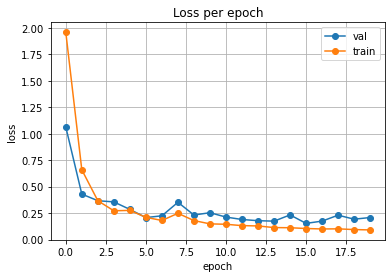

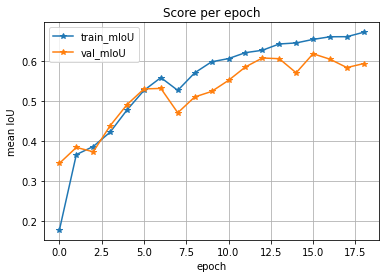

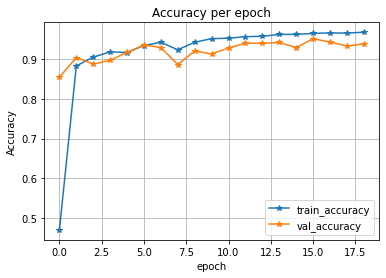

In [26]:
plot_loss(history)
plot_score(history)   
plot_acc(history)

# Evaluation

In [27]:
class CarTestDataset(Dataset):
    
    def __init__(self, img_path, mask_path, X, transform=None):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform
      
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.png')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.X[idx] + '.png')
        mask= mask[:,:,2]
        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']
        
        if self.transform is None:
            img = Image.fromarray(img)
        
        mask = torch.from_numpy(mask).long()
        
        return img, mask


t_test = A.Resize(320, 416, interpolation=cv2.INTER_NEAREST)
test_set = CarTestDataset(CFG.IMAGE_PATH, CFG.MASK_PATH, X_test, transform=t_test)

## Result

In [28]:
def predict_image_mask_miou(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():
        
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        output = model(image)
        score = mIoU(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, score

In [29]:
def predict_image_mask_pixel(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():
        
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        output = model(image)
        acc = pixel_accuracy(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, acc

In [30]:
image, mask = test_set[3]

pred_mask, score = predict_image_mask_miou(model, image, mask)

In [31]:
def miou_score(model, test_set):
    score_iou = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, score = predict_image_mask_miou(model, img, mask)
        score_iou.append(score)
    return score_iou

In [32]:
mob_miou = miou_score(model, test_set)

  0%|          | 0/100 [00:00<?, ?it/s]

In [33]:
def pixel_acc(model, test_set):
    accuracy = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, acc = predict_image_mask_pixel(model, img, mask)
        accuracy.append(acc)
    return accuracy

In [34]:
mob_acc = pixel_acc(model, test_set)

  0%|          | 0/100 [00:00<?, ?it/s]

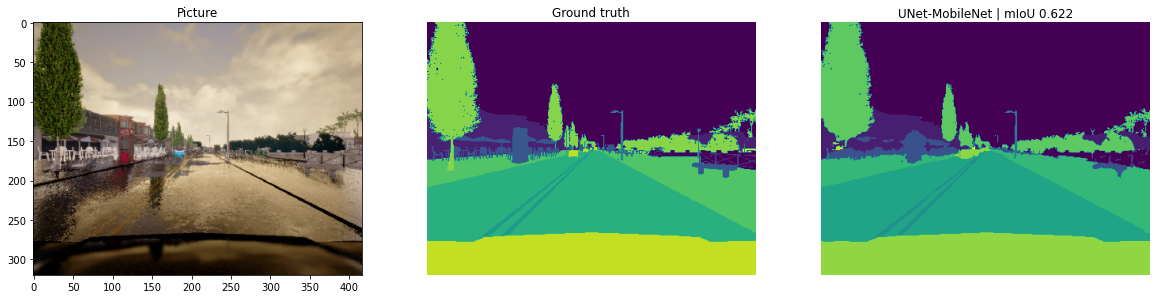

In [35]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Picture');

ax2.imshow(mask)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask)
ax3.set_title('UNet-MobileNet | mIoU {:.3f}'.format(score))
ax3.set_axis_off()

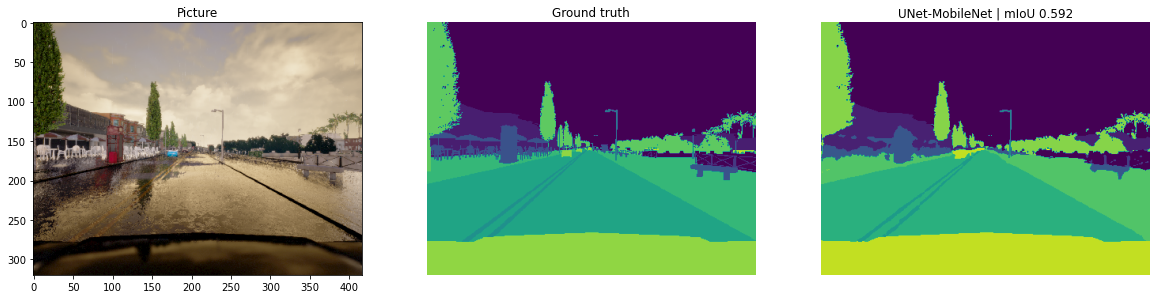

In [36]:
image2, mask2 = test_set[4]
pred_mask2, score2 = predict_image_mask_miou(model, image2, mask2)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image2)
ax1.set_title('Picture');

ax2.imshow(mask2)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask2)
ax3.set_title('UNet-MobileNet | mIoU {:.3f}'.format(score2))
ax3.set_axis_off()

In [37]:
mask2.max()

tensor(12)

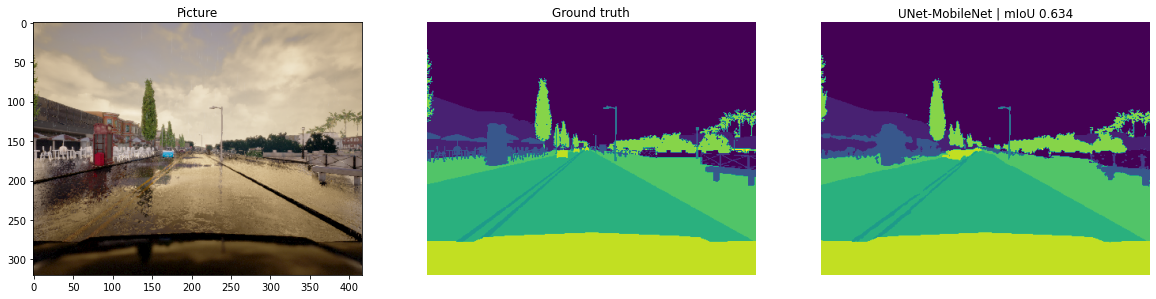

In [38]:
image3, mask3 = test_set[6]
pred_mask3, score3 = predict_image_mask_miou(model, image3, mask3)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image3)
ax1.set_title('Picture');

ax2.imshow(mask3)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask3)
ax3.set_title('UNet-MobileNet | mIoU {:.3f}'.format(score3))
ax3.set_axis_off()

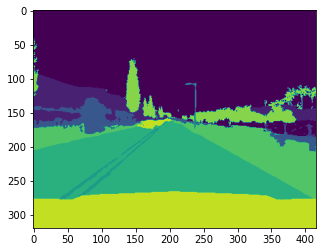

In [39]:
plt.imshow(pred_mask3)

In [40]:
print('Test Set mIoU', np.mean(mob_miou))

Test Set mIoU 0.5829822879195273


In [41]:
print('Test Set Pixel Accuracy', np.mean(mob_acc))

Test Set Pixel Accuracy 0.9614323167067309


# Create Outputs Videos 

In [42]:
output_prefix = f'output_video_{CFG.current_fold}'
acc_lst = []

# Define the frame width, height, and frames per second
frame_width, frame_height = np.asarray(image3).shape[1], np.asarray(image3).shape[0]
fps = 9

# Define the codec and create VideoWriter objects for each video
fourcc = cv2.VideoWriter_fourcc(*'XVID')

original_video_out = cv2.VideoWriter(f"{output_prefix}_original.mp4", fourcc, fps, (frame_width, frame_height))
mask_video_out = cv2.VideoWriter(f"{output_prefix}_mask.mp4", fourcc, fps, (frame_width, frame_height))
combined_video_out = cv2.VideoWriter(f"{output_prefix}_combined.mp4", fourcc, fps, (frame_width, frame_height))

for image, mask in tqdm(test_set):
    img = np.asarray(image)
    mask_array = np.array(mask)
    pred_mask, acc = predict_image_mask_pixel(model, image, mask)
    acc_lst.append(acc)
    colored_mask = np.zeros((mask_array.shape[0], mask_array.shape[1], 3), dtype=np.uint8)
    for row in range(mask_array.shape[0]):
        for col in range(mask_array.shape[1]):
            class_id = mask_array[row, col]
            colored_mask[row, col] = color_map[class_id]
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    img_with_mask = cv2.addWeighted(img, 1, colored_mask, 0.6, 0)

    # Write frames to the videos
    original_video_out.write(img)
    mask_video_out.write(colored_mask)
    combined_video_out.write(img_with_mask)

# Release the VideoWriter objects
original_video_out.release()
mask_video_out.release()
combined_video_out.release()

df = pd.DataFrame(acc_lst, columns=['acc'])

# Save the DataFrame as a CSV file
csv_filename = f'acc_dataframe_{CFG.current_fold}.csv'
df.to_csv(csv_filename, index=False)  # Set index=False to exclude row indices

print(f"DataFrame saved as {csv_filename}")

  0%|          | 0/100 [00:00<?, ?it/s]

DataFrame saved as acc_dataframe_5.csv
